In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

def my_reducer(a):
    return pd.to_datetime(a[0])

reducer = np.vectorize(my_reducer)

In [2]:
spy = pd.read_csv('C:/Users/arkilic/Desktop/spy.csv', 
                      header=0, sep=' ')
spy_design = pd.read_csv('C:/Users/arkilic/Desktop/spy_design.csv', 
                         header=0, sep=' ',  parse_dates=True)
spy_indices = spy.index.values
spy_design_indices = spy_design.index.values


spy_indexes = reducer(spy_indices)
spy['TIME'] = spy_indexes

spy_design_indexes = reducer(spy_design_indices)
spy_design['TIME'] = spy_design_indexes

spy = spy.set_index('TIME')
spy_design = spy_design.set_index('TIME')

In [3]:
spy_data = spy.ix[:, 1:6]
spy_data.head()

,SPY.Open,SPY.High,SPY.Low,SPY.Close,SPY.Volume
TIME,,,,,
2008-01-02 09:31:00,146.535,146.645,146.535,146.645,591203.0
2008-01-02 09:32:00,146.645,146.685,146.635,146.685,385457.0
2008-01-02 09:33:00,146.685,146.775,146.680,146.775,343700.0
2008-01-02 09:34:00,146.725,146.755,146.705,146.725,863418.0
2008-01-02 09:35:00,146.705,146.775,146.685,146.775,457500.0


In [4]:
spy_design_data = spy_design.ix[:, 1:7]
spy_design_data.head()


spy = spy_data
spy_design = spy_design_data

In [5]:
spy_design.head()

,returns,returns.WA5,variance,skew,hurst,rets_var
TIME,,,,,,
2008-01-02 09:31:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-01-02 09:32:00,0.707107,0.707107,0.707107,-0.707107,0.000000,0.707107
2008-01-02 09:33:00,1.034910,1.031794,1.027297,-0.901304,0.000000,1.133169
2008-01-02 09:34:00,-1.177622,-0.712844,1.407897,1.277819,0.000000,-1.366479
2008-01-02 09:35:00,0.451147,-0.181499,0.593341,-1.669053,-1.788854,0.854902


In [6]:
def diff_xts(x_ts, lag=1, differences=1, arithmetic=True):
    # Uses something along the lines of numpy.diff for lag
    """
    Parameters
    ----------
    x_ts: pd.DataFrame
        Raw data
    lag: int
        period to difference over
    differences: int
        order of differencing
    arithmetic: bool
        should arithmetic or geometric differencing be used
    """
    if lag != 1:
        raise NotImplementedError('Period other than 1 has not beein implemented yet')
    res = np.zeros(x_ts.shape[0])
    res[1:] = np.diff(x_ts.ix[:, 1])
    return  res# vectorized diff over given period

In [7]:
def run_returns(x_ts, col_umn = 3):
    if len(x_ts.columns) == 7:
        re_turns = 0.5 * (x_ts[:]["Bid.Price"] + x_ts[:]["Ask.Price"])
    else:
        re_turns = x_ts[x_ts.columns[::col_umn]]
    ind_diff = np.ones(x_ts.shape[0])    
    ind_diff[1:] = np.multiply(np.diff(x_ts.index.values), 10e-10)
    x_ts['returns'] = 86400 * diff_xts(re_turns) / ind_diff
    return x_ts

In [8]:
returns_running = run_returns(spy)['returns']

In [9]:
returns_running.head()

TIME
2008-01-02 09:31:00      0.0
2008-01-02 09:32:00     57.6
2008-01-02 09:33:00    129.6
2008-01-02 09:34:00    -72.0
2008-01-02 09:35:00     72.0
Name: returns, dtype: float64

In [10]:
%timeit run_returns(spy)

10 loops, best of 3: 28.8 ms per loop


In [11]:
def lag_xts(x_ts, k=-1, **kwargs):
    n_rows = x_ts.shape[0]
    fir_st = x_ts[0]
    la_st = x_ts[n_rows-1]
    x_ts = x_ts.shift(periods=k, **kwargs)
    if (k > 0):
        print(fir_st)
        x_ts[0:k] = fir_st
    else:
        x_ts[n_rows-1] = la_st
    return x_ts

In [12]:
returns_advanced = lag_xts(returns_running)
returns_advanced.name = 'returns_advanced'
print(returns_advanced.head())

TIME
2008-01-02 09:31:00     57.6
2008-01-02 09:32:00    129.6
2008-01-02 09:33:00    -72.0
2008-01-02 09:34:00     72.0
2008-01-02 09:35:00    -57.6
Name: returns_advanced, dtype: float64


In [13]:
# betas_running <- roll_pcr(x=SPY_design["2011/2012", ], 
#                           y=returns_advanced["2011/2012", ], 
#                           width=1*60, comps=1:1, min_obs=1)
x = spy_design['2011': '2012']
y = returns_advanced['2011': '2012']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression

%matplotlib inline

C:\Users\arkilic\Anaconda3\envs\quantfin\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**roll_pcr(x, y, width, comps = 1:ncol(x), weights = rep(1, width),
  center = TRUE, scale = FALSE, min_obs = width, complete_obs = TRUE,
  na_restore = FALSE, parallel_for = c("rows", "cols"))
Arguments
x
matrix or xts object. Rows are observations and columns are the independent variables.
y
matrix or xts object. Rows are observations and column is the dependent variable.
width
integer. Window size.
comps
integer vector. Select a subset of principal components.
weights
vector. Weights for each observation within a window.
center
logical. If TRUE then the weighted mean of each variable is used, if FALSE then zero is used.
scale
logical. If TRUE then the weighted standard deviation of each variable is used, if FALSE then no scaling is done.
min_obs
integer. Minimum number of observations required to have a value within a window, otherwise result is NA.
complete_obs
logical. If TRUE then rows containing any missing values are removed, if FALSE then pairwise is used.
na_restore
logical. Should missing values be restored?
parallel_for
character. Executes a "for" loop in which iterations run in parallel by rows or cols.
Value
A list containing the following components:
coefficientsAn object of the same class and dimension as x with the rolling coefficients.
r.squaredAn object of the same class as x with the rolling r-squareds.



**The PCR method may be broadly divided into three major steps:**

1.) 
\;\; Perform PCA on the observed data matrix for the explanatory variables to obtain the principal components, and then (usually) select a subset, based on some appropriate criteria, of the principal components so obtained for further use.

2.) 
\;\; Now regress the observed vector of outcomes on the selected principal components as covariates, using ordinary least squares regression (linear regression) to get a vector of estimated regression coefficients (with dimension equal to the number of selected principal components).

3.) 
\;\; Now transform this vector back to the scale of the actual covariates, using the selected PCA loadings (the eigenvectors corresponding to the selected principal components) to get the final PCR estimator (with dimension equal to the total number of covariates) for estimating the regression coefficients characterizing the original model.


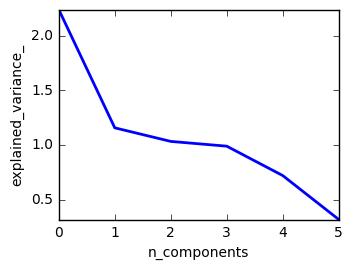

In [14]:
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

linear = linear_model.LinearRegression()
# use linear regression instead

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', linear)])

pca.fit(x)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [16]:
n_components = [1, 2, 4]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
# estimator.fit(x, y)

# plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
#             linestyle=':', label='n_components chosen')
# plt.legend(prop=dict(size=12))
# plt.show()


In [17]:
pca = PCA(n_components=1)

In [18]:
pca.fit_transform(x, y)
print(pca.explained_variance_ratio_) 
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


[ 0.34695659]


array([ 34.7])

In [19]:
pca.fit_transform(spy_design['2011': '2013'])
print(pca.explained_variance_ratio_) 

[ 0.34707481]


In [20]:
x_ax = spy_design['12/2011': '01/2012'].index.values
y_ax = spy_design['12/2011': '01/2012']['returns']

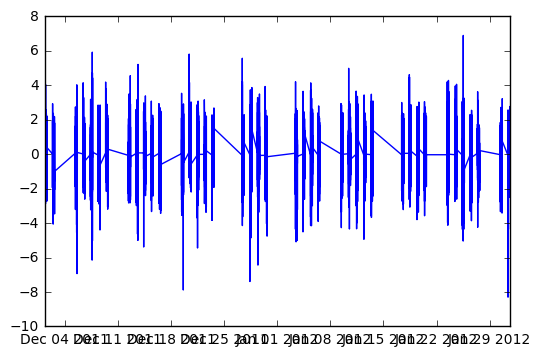

In [21]:
plt.close
plt.plot(x_ax, y_ax)

In [22]:
m_list = []
def list_er(sm_list):
    sm_list.append('a')
    return sm_list
k = list_er(m_list)
print(m_list, k)

['a'] ['a']


In [23]:
a = 'A'

b = 'b'

a < b

True

In [21]:
a = {('a', 'b'): 1}

In [22]:
a

{('a', 'b'): 1}

In [23]:
a[('a', 'b')]

1

In [24]:
from sklearn.cross_decomposition import PLSRegression

In [25]:
pls2 = PLSRegression(n_components=2)
pls2.fit(x, y)
Y_pred = pls2.predict(x)

In [26]:
Y_pred

array([[ -0.02499396],
       [-10.57219086],
       [  0.7692534 ],
       ..., 
       [  0.65935632],
       [ -3.51331393],
       [ -0.05000579]])